# Notebook contents/structure

* **1** User to input primary variables
    * a) Define geographic variables *(primarily referenced to single closest tide post. Sub-polygon splitting, where user defined bounding box crosses multiple voronoi cells/tide posts to be added later)*
    * b) User to define where their outputs are to be saved
    
    
* **2** Generate global model and observation datasets for given location, for 1986 to present *(Automate all processeing in the notebook back-end. Show only the plot of global values. Save csv files of model and observations, as well as the plot to user designated folder)*
    * a) Import all modules
    * b) Determine modelled tide heights and dates
    * c) Find all satellite observations
    * d) Tag all observations as ebbing or flowing
    * e) Save modelled values and observations as separate dataframes
    * f) Plot all available information for a given site (model and obs). Show every 10th percentile of the observed tide range with a labelled horizontal line
    
    
* **3** User to define secondary variables
    * Complete time range of interest *(epochs and tidal percentile ranges calculated from this time range)*
    * Epoch length *(How many of years of data to include in every composite)*
    * Tidal range of interest *(Composites are produced for observations between these values/percentiles)*
        * Upper percentile of tidal range
        * Lower percentile of tidal range
    * Tidal stages of interest
        * Ebb
        * Flow
        * Peak high
        * Peak low
        * All
        
        
* **4** Generate dataset of interest and plot composites and data summary with interactive functionality (*Move all code to notebook back end. Show only the composite images and data summary plot. Note the saved file names and storage location in the output cell*)
    * If the user-defined complete time range differs from default (1986 - present) then generate the statistical baseline from the user-defined time range to draw the tidal percentiles from
    * Sub-sample the observations to generate data for the tidal stages of interest, in the defined percentile range, for each epoch
    * Plot composite images of each epoch
    * Plot the data summary, with colour coding to show which observations were input into each composite. Include interactive functionality for investigation of individual input images.
    * Save each plot and a csv file with the input data to the users designated storage space
    
    
* **5** Allow users to explore individual scenes via interactive plot
    * Have a non-code cell, instrucing users how to use the interactive plot *i.e. Using the mouse, click once on an observation on the plot then run the cell/s below. The observation recorded closest in time to the mouse click will be returned below*
    * Bring in the code to return the closest image *(Hide in the notebook backend. Output the scene only, noting the time/date it was captured and where the image has been saved to)*
    
**Notebook end**

In [105]:
# 1. User to define primary variables

## Geographic variables##

LOC = 'Polygon_216' #Include a loction name for area of interest to simplify file naming

# NOTE use only lat/long/tide post OR filepath and polygon ID. Comment out what you don't need.

#     # 1ai) Lat/long bounding box
lon_range = '(151.60, 151.70)'
lat_range = '(-23.15, -23.25)'
#     # 1aii) Tide post
# lon = 151.23
# lat = -22.99

#     # 1b) polygon
# 
# #'/g/data/r78/cp7765/agdc_tidal/GA_tidal_model.shp'
# #u46/users/bxb547/otps/vector_data/GA_tidal_model.shp'
# polygon = 216 # 306 polygons around Australian coastline. Insert Id for polygon of interest
# lon = 123.29  # polygon centroid longitude. Source from attribute_table.csv in g/data/r78/cp7765/agdc_tidal
# lat = -16.79  # polygon centroid latitude. Source from attribute_table.csv in g/data/r78/cp7765/agdc_tidal
# lon_range = (lon-0.05, lon + 0.05)
# lat_range = (lat+0.05, lat - 0.05)
print ("Variables accepted ")

Variables accepted 


# To do: update co-ordinates to handle multiple tide-posts when selecting boundary box lat's and long's#

In [106]:
# 2. Generate global modelled and observed datasets for location, from 1986 to present.
#    User only sees data summary plot in their output cell

#Run for entire archive of datasets to extract observed tide height on those UTC time

# 2a) Import all modules
print ("2a) Import modules")
from shapely.geometry import Point, Polygon, MultiPolygon, mapping, shape
from fiona import collection
import fiona
import shapely
import rasterio.features
import datacube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datacube.utils import geometry
from datacube.api.grid_workflow import GridWorkflow
from datacube.api.query import query_group_by
import numpy as np
import itertools
from datetime import date, datetime, timedelta
import otps
import sys
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from operator import itemgetter
import numpy as np
import itertools
from datetime import date, datetime, timedelta
import otps
import sys
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import itertools
import matplotlib as mpl
from IPython.display import display

print ('2a) Complete: modules imported ' +str(datetime.now()))

2a) Import modules
2a) Complete: modules imported 2017-05-16 15:08:54.059404


In [107]:
## Testing cell to bring in bounding box code
## Section 2aa
from datetime import date, datetime, timedelta

#Run for entire archive of datasets to extract observed tide height on those UTC time

native_path = '/g/data/r78/intertidal/GA_native_tidal_model.shp'



#these are the datasets we are using observations from for global values
#products = ['ls5_pq_albers', 'ls8_pq_albers'] # these are the datasets we are using observations from when time_period begins after 2003
products = ['ls5_pq_albers', 'ls7_pq_albers', 'ls8_pq_albers'] 

time_period=('1986-01-01', '2018-01-01') # this is a global time range. Global=('1986-01-01', '2018-01-01')
LS7_SLC_DT = datetime.strptime("2003-05-01", "%Y-%m-%d")

points = list()
lon1 = eval(lon_range)[0]
lon2 = eval(lon_range)[1]
lat1 = eval(lat_range)[0]
lat2 = eval(lat_range)[1]

point1 = Point(lon1,lat1)
point2 = Point(lon1,lat2)
point3 = Point(lon2,lat1)
point4 = Point(lon2,lat2)

ID = 0
lon = 0
lat = 0
tp = list()
all_times_dict = dict()

def search_point(point=point1):
    with fiona.open(native_path) as Input:
    #crs = geometry.CRS(str(Input.crs_wkt))
        for feature in Input:
            ID = feature['properties']['ID']            
            if feature['geometry']['type'] == "MultiPolygon":
            #polygon = MultiPolygon(feature['geometry'])               
                if point.within(shape(feature['geometry'])):
                    print ("Found feature in " + str(ID))
                    lon = feature['properties']['lon']
                    lat = feature['properties']['lat']
                    return ID, lon, lat
            else: 
                polygon = Polygon(feature['geometry']['coordinates'][0])
            
            if polygon.contains(point): 
                lon = feature['properties']['lon']
                lat = feature['properties']['lat']
                return ID, lon, lat
        return 0
def get_dataset_dates(lon, lat):
    dc=datacube.Datacube(app='test')
    all_time = list()
    for source in products:
        time_range = time_period
        if source == 'ls7_pq_albers' and (datetime.strptime(time_range[0], "%Y-%m-%d") > LS7_SLC_DT):
            continue
        time_range = (time_range[0], LS7_SLC_DT) if source == 'ls7_pq_albers' and \
                     (datetime.strptime(time_range[1], "%Y-%m-%d")  > LS7_SLC_DT) else time_period
        print ("finding datasets for " + source + " in " + str(time_range))
        ds = dc.find_datasets(product=source, time=time_range, x = eval(lon_range), y= eval(lat_range))
        group_by = query_group_by(group_by='solar_day')
        sources = dc.group_datasets(ds, group_by)
        if len(ds) > 0 :
            all_time = all_time + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
            all_time = sorted(all_time)    
 
    print ("tide post selected " + str(lon) + str(lat))
    return all_time
#     for dt in all_times:
#         tp.append(TimePoint(lon, lat, dt))
#     tides = predict_tide(tp)
#     tide_dic = dict()

#     for tt in tides:
#         tide_dic[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m

#     tide_data = sorted(tide_dic.items(), key=lambda x: x[1])
#     print (sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in tide_data]))
#     return tide_data


if search_point(point1)[0] > 0 and search_point(point2)[0] > 0 and search_point(point3)[0] > 0 : 
    ID, lon, lat = search_point(point4)
    if ID > 0:
        print ("coordinates are within polygon " + str(ID))
        print ("tide post found in " + str(lon) + "," + str(lat))
        all_times_dict['date_range'] = get_dataset_dates(lon, lat)
        polygon=ID
        #print (polygon)
            
    else:
        print ("Not allowed for multiple polygons. Please refer to GA tidal model shape file")
else :
    print ("Not allowed for multiple polygons. Please refer to GA tidal model shape file")   


print ("Co-ordinate attribution is complete")


coordinates are within polygon 177
tide post found in 151.69,-23.18
finding datasets for ls5_pq_albers in ('1986-01-01', '2018-01-01')
finding datasets for ls7_pq_albers in ('1986-01-01', datetime.datetime(2003, 5, 1, 0, 0))
finding datasets for ls8_pq_albers in ('1986-01-01', '2018-01-01')
tide post selected 151.69-23.18
Co-ordinate attribution is complete


2b) Start: determine all modelled tide heights and dates for global time range for lon 151.69, lat -23.18, 2017-05-16 15:09:22.246403
2b) Complete: 2017-05-16 15:10:05.026280
2c) Start: Find all satellite observations for global time range
Polygon File not found 
Attributing tide height to satellite observations
2c) Complete: compiled and attributed tide height to all satellite observations between 1986 and the present forPolygon_2162017-05-16 15:10:10.226027
2d) Start: append ebb, flow, peak high and peak low to observations
2d) Complete: tidal stage attributed to satellite observations 2017-05-16 15:10:15.567233
2e) Start: plot preparation - create dataframes for modelled and observed datasets
2e) Complete 2017-05-16 15:10:16.097608
Populating the interactive namespace from numpy and matplotlib
2f) Start: plot global data summary for Polygon_216


/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'datetime', 'cos', 'shape', 'Polygon', 'sqrt', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


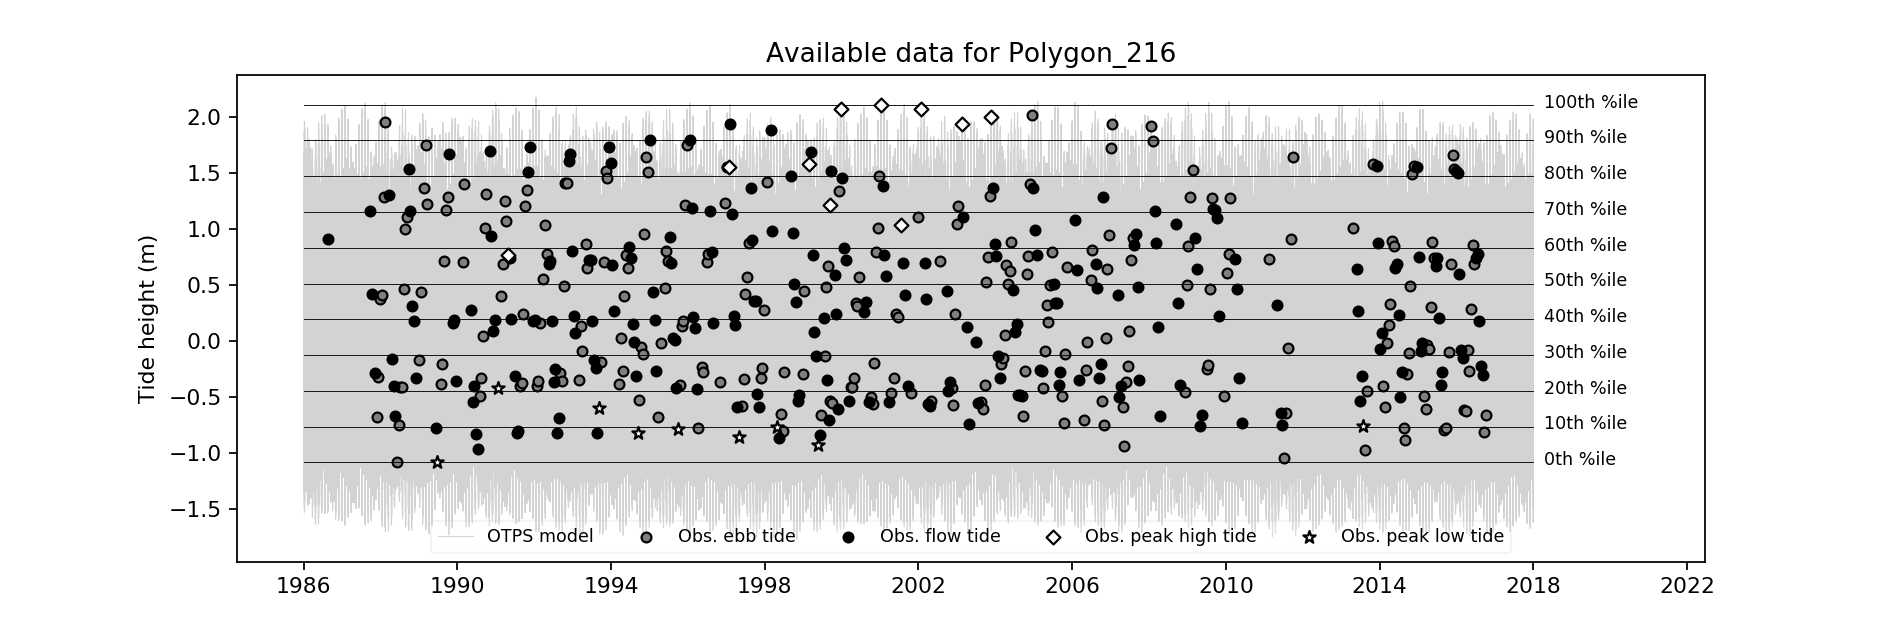

In [108]:
# 2b) Determine all modelled tide heights and dates for global time range
from datetime import date, datetime, timedelta

def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

start = datetime.strptime(time_period[0] + " 00:00:00", "%Y-%m-%d %H:%M:%S")
end = datetime.strptime(time_period[1] + " 00:00:00", "%Y-%m-%d %H:%M:%S")

tp_model = list()
tide_det = list()
print ("2b) Start: determine all modelled tide heights and dates for global time range for lon "+ str(lon) +', lat ' + \
str(lat) + ", " + str(datetime.now()))
#print ("starting", str(datetime.now()) + " for lon " + str(lon) +', lat ' + str(lat))
for string_date in date_range(start, end, 1, 'hours'):
    dt_model = datetime.strptime(str(string_date), "%Y-%m-%d %H:%M:%S")
    tp_model.append(TimePoint(lon, lat, dt_model))                    

#print ("added to the list", str(datetime.now()))

tides_model = predict_tide(tp_model)
#print ("received from predict tides", str(datetime.now()))

for tt in tides_model:
    tide_det.append([tt.timepoint.timestamp.isoformat()[0:10], tt.tide_m])
#print ("Complete: modelling of date and tide height for " + LOC + " between 1986 and present", str(datetime.now()))
print ("2b) Complete: " + str(datetime.now()))

# 2c) Find all satellite observations for global time range

print ("2c) Start: Find all satellite observations for global time range")

    #Note: the products definition has been moved upwards into the section (2aa) defining a user-defined bounding box
dc=datacube.Datacube(app='test') # is this line required?

tp=list()

filepath=''
#filepath = '/g/data/r78/cp7765/agdc_tidal/GA_tidal_model.shp'

try:
    all_times = list()
    with fiona.open(filepath) as Input:
        crs = geometry.CRS(str(Input.crs_wkt))
        for feature in Input:
            lon = feature['properties']['lon']
            lat = feature['properties']['lat']
            Id = feature['properties']['ID']
            
            
            if Id == polygon:
                print ("Confirm co-ords and tide post " + str(lon)+", " + str(lat)+", " + str(Id))
                first_geometry = feature['geometry']
                geom = geometry.Geometry(first_geometry, crs=crs)
                                
                for source in products:                 
                    time_range = ('1986-01-01', '2003-05-01') if source == 'ls7_pq_albers' else time_period ## this line\
                    ## requires editing with a date exception for the ls7 time range, dependent on the time_period. e.g\
                    ## if time_period = 2010 to 2017, the global data summary plot has issues plotting.
                    ds = dc.find_datasets(product=source, time=time_range, geopolygon=geom, group_by='solar_day')
                    group_by = query_group_by(group_by='solar_day')
                    sources = dc.group_datasets(ds, group_by)
                    if len(ds) > 0 :
                        all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
                    all_times = sorted(all_times)            
                break
except IOError as e:
    print ("Polygon File not found ")
                
### For use when co-ordinates are lat/long bounding box rather than ITEM polygons 
# if len(lon_range) > 0:
#     for source in products:
#         time_range = ('1986-01-01', '2003-05-01') if source == 'ls7_pq_albers' else time_period
#         print "finding datasets for " + source + " in " + str(time_range)
#         ds = dc.find_datasets(product=source, time=time_range, x = eval(str(lon_range)), y= eval(str(lat_range)))
#         group_by = query_group_by(group_by='solar_day')
#         sources = dc.group_datasets(ds, group_by)
#         if len(ds) > 0 :
#             all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
#             all_times = sorted(all_times)
    

#print ("tide post selected " + str(lon) + str(lat))
print ("Attributing tide height to satellite observations")
all_times= all_times_dict['date_range']

for dt in all_times:
    tp.append(TimePoint(lon, lat, dt))
tides = predict_tide(tp)
tide_dic = dict()

for tt in tides:
    tide_dic[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m


tide_data = sorted(tide_dic.items(), key=lambda x: x[1])

#print (sorted([[x[0].strftime('%Y-%m-%d %H:%M:%S'), x[1]] for x in tide_data]))
print ("2c) Complete: compiled and attributed tide height to all satellite observations between 1986 and the present for\
" + LOC + str(datetime.now()))

# 2d) Append ebb, flow, peak high and peak low to observations
print ("2d) Start: append ebb, flow, peak high and peak low to observations")

# Create dataframe of tide heights, indexed by date/time (UTC)

df1_data = {'Tide_height': list((x[1] for x in sorted(tide_data)))}
df1_index = list(x[0].strftime("%Y-%m-%dT%H:%M:%S") for x in sorted (tide_data))
df1 = pd.DataFrame(df1_data, df1_index)

# Using OTPS model, determine tidal stage of each observation
# Ebb/flow is determined by tide height 15 minutes before and after each observation

stagecalc_list=list()
tp_ebbflow = list()
tide_dict_ebbflow = dict()

mnt=timedelta(minutes=15)

for dt in df1_index:
    dt = datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
    stagecalc_list.append(dt-mnt)
    stagecalc_list.append(dt)
    stagecalc_list.append(dt+mnt)
    
for dt in stagecalc_list:
    tp_ebbflow.append(TimePoint(lon, lat, dt))
    
tide_stage = predict_tide(tp_ebbflow)

for tt in tide_stage:
    tide_dict_ebbflow[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m 
    
tmp_lt = sorted(tide_dict_ebbflow.items(), key=lambda x: x[0])

tmp_lt = [[tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"), 'ph'] \
         if tmp_lt[i][1] < tmp_lt[i+1][1] and tmp_lt[i+2][1] <  tmp_lt[i+1][1]  else \
        [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"), 'pl'] if tmp_lt[i][1] > tmp_lt[i+1][1] and \
        tmp_lt[i+2][1] >  tmp_lt[i+1][1]  else [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"),'f'] \
        if tmp_lt[i][1] < tmp_lt[i+2][1] else [tmp_lt[i+1][0].strftime("%Y-%m-%dT%H:%M:%S"),'e'] \
         for i in range(0, len(tmp_lt), 3)]

ebb_flow = str([tt for tt in tmp_lt ])   
key = set(e[0].strftime("%Y-%m-%dT%H:%M:%S") for e in tide_data)
ebb_flow_tides = [ff for ff in eval(ebb_flow) if ff[0] in key]

# Add ebb/flow tide stages to the tide height dictionary, in preparation for storage in dataframe

df1_tidestage = {'Tide_stage': list((x[1] for x in sorted(ebb_flow_tides)))}
df1_data.update(df1_tidestage)

print ('2d) Complete: tidal stage attributed to satellite observations ' + str(datetime.now()))

# 2e) Save modelled and observed datasets into separate dataframes, in preparation to plot
print ("2e) Start: plot preparation - create dataframes for modelled and observed datasets")

# Observations: date, tide height, tide stage (Update index to show dates only)
df1_index = list(x[0].strftime('%Y-%m-%d') for x in sorted (tide_data))

df1_obs = pd.DataFrame(df1_data, index=df1_index)
# print (df1_obs.head(20))

# Model: date, tide height
df2_data = {'Model_height': list(x[1] for x in sorted(tide_det))}
df2_index = list(x[0] for x in sorted (tide_det))
df2_model = pd.DataFrame(df2_data, index=df2_index)
#print (df2_model.head(10))

print ('2e) Complete ' + str(datetime.now()))

% pylab notebook
# 2f) Plot global modelled tide heights and dates against all observations for given location
print ("2f) Start: plot global data summary for " + str(LOC))

# Plot setup
fig = plt.figure(figsize=(12,4))
mpl.rcParams['agg.path.chunksize'] = 10000
plt.ylabel('Tide height (m)')
#fig.canvas.mpl_connect('button_press_event', callback)
#plt.legend() #(bbox_to_anchor=(0,-0.3), loc='center left')
plt.title('Available data for ' + LOC)

# Data series
# Prepare x-axis
obs_index = pd.DatetimeIndex(df1_index)
obs_index = obs_index.to_datetime()
obs_index = np.array(obs_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot observations
#scatter(obs_index, df1_obs.Tide_height, s=20, color='red', marker='o', zorder=2, label = 'observations') # All observations

# Plot tide stages
df_e = df1_obs.query('Tide_stage == "e"')
df_e_index = pd.DatetimeIndex(df_e.index)
df_e_index = df_e_index.to_datetime()
df_e_index = np.array(df_e_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_e_index, df_e.Tide_height, s=20, color='gray', marker='o', edgecolors='black', zorder=2, label = 'Obs. ebb tide')

df_f = df1_obs.query('Tide_stage == "f"')
df_f_index = pd.DatetimeIndex(df_f.index)
df_f_index = df_f_index.to_datetime()
df_f_index = np.array(df_f_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_f_index, df_f.Tide_height, s=20, color='black', marker='o', zorder=3, label = 'Obs. flow tide')

df_ph = df1_obs.query('Tide_stage == "ph"')
df_ph_index = pd.DatetimeIndex(df_ph.index)
df_ph_index = df_ph_index.to_datetime()
df_ph_index = np.array(df_ph_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_ph_index, df_ph.Tide_height, s=20, edgecolors='black', color='white', marker='D', zorder=4, label = 'Obs. peak high tide')

df_pl = df1_obs.query('Tide_stage == "pl"')
df_pl_index = pd.DatetimeIndex(df_pl.index)
df_pl_index = df_pl_index.to_datetime()
df_pl_index = np.array(df_pl_index.to_pydatetime(), dtype = numpy.datetime64)
scatter(df_pl_index, df_pl.Tide_height, s=35, edgecolors='black', color='white', marker='*', zorder=5, label = 'Obs. peak low tide')


## Model values
# Prepare x-axis
model_index = pd.DatetimeIndex(df2_index)
model_index = model_index.to_datetime()
model_index = np.array(model_index.to_pydatetime(), dtype = numpy.datetime64)
# Plot model values
plot(model_index, df2_model.Model_height, color='lightgray', linewidth=0.5, zorder=1, label = 'OTPS model')

## Percentile ranges (from observations)
# Determine tide height at every 10th percentile of the observed tide range to plot on global data fig
sub_data = [[x[0], x[1]] for x  in tide_data] 
min_height=sub_data[0][1]
max_height=sub_data[-1][1]
dr = float(max_height)-float(min_height) # Max tidal range

per10_list = []
for PERC in range(0,110,10):
    lmr = float(min_height) + dr*float(PERC)*0.01   # low tide max range
    #p#er10_dict=[PERC]
    per10_list.append([PERC, lmr]) 
    
per10_data = {'PERC_tide_height': list(x[1] for x in sorted(per10_list))}
per10_index = list(x[0] for x in sorted(per10_list))
df_per10 = pd.DataFrame(per10_data, per10_index)


for i in per10_list:
    plot([model_index[0], model_index[-1]], [df_per10.PERC_tide_height[i],df_per10.PERC_tide_height[i]], 'black', \
         linewidth=0.4)# , label= str(a) + 'th %ile of obs')
    plt.text(model_index[-1] + 100, i[1] - 0.025, str(i[0])+'th %ile', fontsize=8)

plot([(model_index[0]), (model_index[-1]+1000)], [(df_per10.PERC_tide_height[0] - 0.3),df_per10.PERC_tide_height[0]],\
     'none', linewidth=0)# , label= str(a) + 'th %ile of obs')
        
plt.legend(loc='lower center', prop={'size':8}, ncol=5, fancybox=True, framealpha=0.2) #, bbox_to_anchor=(0,-0.1))
plt.savefig('Global_data_summary_for_' + str(LOC) + '_' + str(lat) +"_"+ str(lon) +'_.jpeg')
plt.show()

In [109]:
# 3. Define variable to generate composite imagery

# What is your total time period of interest?
time_range = ['2007-01-01', '2017-01-01']  # Default 1988 to present (whole archive). ('YYYY-MM-DD','YYYY-MM-DD') format

# How many years do you wish to view in each composite?
epoch = 5                                  # Minimum is 1 year. Positive integers only.

# What is your tidal range of interest? Nominate the percentile range between which you wish to view composite imagery.
upper = 25 # Maximum range is 1-100
lower = 0  # Maximum range is 0-99

# # Which tidal stage/s would you like to include in your composites?
# all_stages = 'yes' # Default = yes
# ebb = '' # Default = no
# flow = '' # Default = no
# peak_high = '' # Default = no
# peak_low = '' # Default = no
#This variables are for GEOMEDIAN call

TIDE_POST = "--tide_post " + "'(" + str(lon) + "," + str(lat) + ")'"
EPOCH = "--epoch "+ str(epoch) #default epoch 2
DEB = "--debug"   # To get detail of date/time and tide heights
# LS7FL="--ls7fl"  To include LS7 datasets
#YEAR="--year_range 1986-2017"
#YEAR = "--year_range " + time_range[0][:4] + '-' + time_range[1][:4]
YEAR = "--year_range " + time_range[0] + '_' + time_range[1]
HR = " --date_all_2 "  # This is to pass the tide date list
QT = "'"
LON = "--lon_range " + "'" + lon_range + "'"
LAT = "--lat_range " + "'" + lat_range + "'"

print (YEAR, EPOCH, LON, LAT, TIDE_POST)

--year_range 2007-01-01_2017-01-01 --epoch 5 --lon_range '(151.60, 151.70)' --lat_range '(-23.15, -23.25)' --tide_post '(151.69,-23.18)'


Tide height at 0 percentile: -1.039 m
Tide height at 25 percentile: -0.296 m
doing for epoch2007-01-01_2011-12-31
doing for epoch2012-01-01_2016-12-31
sorted date tide list to pass to geomedian 38
--lon_range '(151.60, 151.70)' --lat_range '(-23.15, -23.25)' --year_range 2007-01-01_2017-01-01  --date_all_2  --epoch 5 --debug
Input date range 2007-01-01_2017-01-01
running task for epoch 2007-01-01 TO 2011-12-31 on percentile 10 tide post  for lon/lat range (151.60, 151.70)(-23.15, -23.25) epoch 5
 doing for sensor ls5_nbar_albers
 epoch end date is reset for LS5 2011/12/01
 doing for sensor ls7_nbar_albers
LS7 post 2003 May data is not included
 doing for sensor ls8_nbar_albers
tide list 
[('2010-05-03', ' -0.327'), ('2007-10-02', ' -0.349'), ('2007-05-27', ' -0.364'), ('2008-10-20', ' -0.395'), ('2007-04-09', ' -0.398'), ('2008-12-07', ' -0.451'), ('2009-12-10', ' -0.488'), ('2007-03-24', ' -0.503'), ('2007-04-25', ' -0.588'), ('2011-06-07', ' -0.638'), ('2011-07-25', ' -0.644'), ('200

<IPython.core.display.Javascript object>


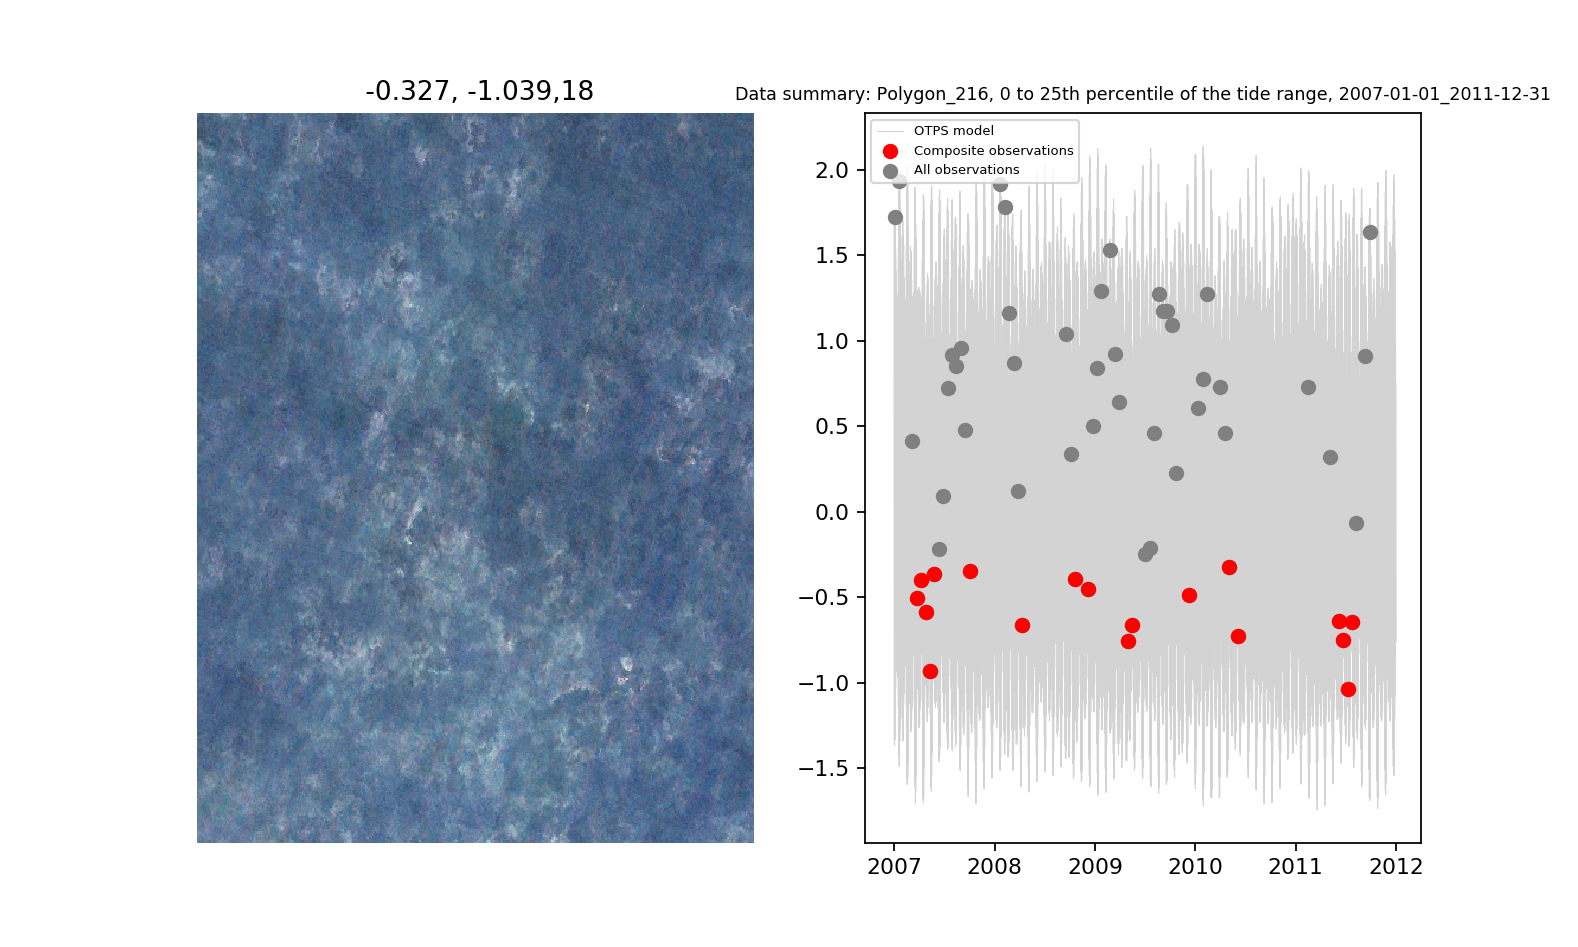

<IPython.core.display.Javascript object>


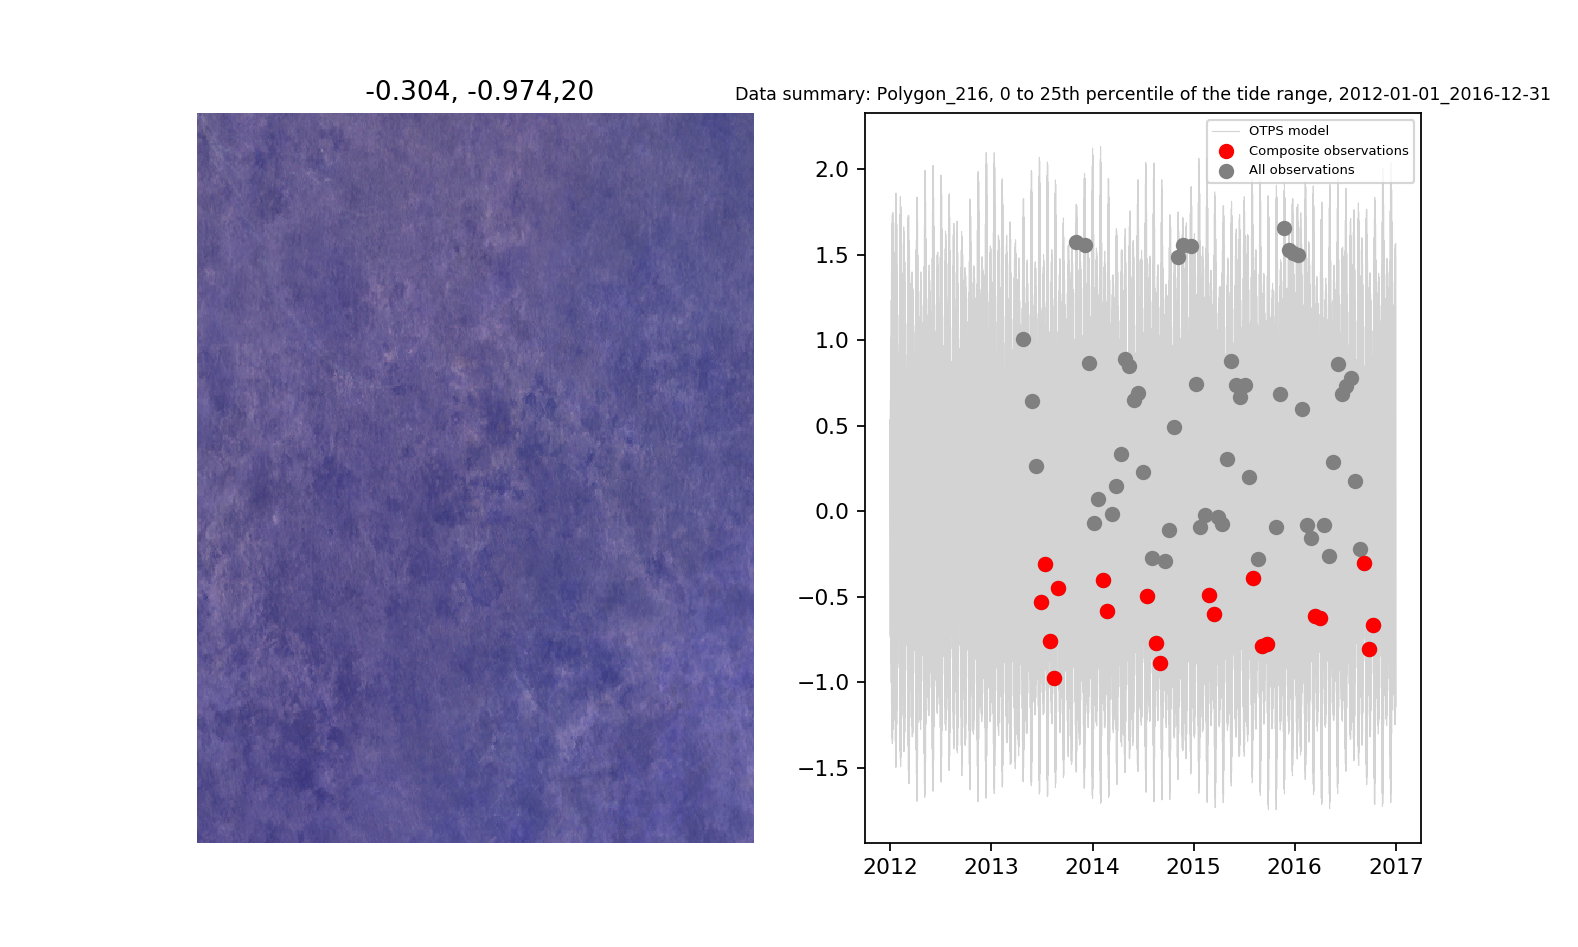

In [156]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# 4. Generate data sub-sets to produce composites and interactive data summary plot
# 4.1 Sub-sample global imagery for location from df1_obs to include only those defined by user in 'time_range'
## Save results into new df3_obs_time_range
df3_obs_time_range = df1_obs.ix[time_range[0]: time_range[1]]

# 4.21 Sub-sample df3_time_range to include only observations located between 'upper' and 'lower' tidal range
## Save results into new df4_obs_tide_range

#Covert percentile request from 'upper' and 'lower' into value for tide height
# 4.4 Generate geomedian values for the bands in the observations of each epoch (from dataframe_collection dict)
Obs_tide_min=df3_obs_time_range.Tide_height.min()
Obs_tide_max=df3_obs_time_range.Tide_height.max()

tide_range=Obs_tide_max - Obs_tide_min
lower_value = Obs_tide_min + (tide_range*lower*0.01)
print ('Tide height at ' +str(lower)+ ' percentile: ' + str(lower_value)+' m')

upper_value = Obs_tide_min + (tide_range*upper*0.01)
print ('Tide height at ' + str(upper)+ ' percentile: ' + str(upper_value) + ' m')

df4_obs_tide_range = df3_obs_time_range[(df3_obs_time_range['Tide_height']>=lower_value) & \
                                        (df3_obs_time_range['Tide_height']<= upper_value)]

# 4.3 Slice dataset into epochs in preparation to plot

START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')

obs_tide_range_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=epoch)
     en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     #print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
     obs_tide_range_epoch[epoch_data] = df4_obs_tide_range.ix[st:en]
     START = START + relativedelta(years=epoch)
        
START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')        
        
all_obs_tide_range_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=epoch)
     en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     #print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
     all_obs_tide_range_epoch[epoch_data] = df1_obs.ix[st:en]
     START = START + relativedelta(years=epoch) 

START = datetime.strptime(time_range[0], '%Y-%m-%d')
END = datetime.strptime(time_range[1], '%Y-%m-%d')        
        
model_epoch = {}
while START < END:
     st = datetime.strftime(START, "%Y-%m-%d")
     en = START + relativedelta(years=epoch)
     en = en - relativedelta(days=1)
     en = datetime.strftime(en, "%Y-%m-%d")
     print ("doing for epoch" + str(st) + "_" +  str(en))
     epoch_data = str(st) + "_" +  str(en)
#      epoch_data = [st:en:1]
     model_epoch[epoch_data] = df2_model.ix[st:en]
     START = START + relativedelta(years=epoch)

LIST = (sorted(model_epoch.keys()))        

# 4.5 Plot composites
# For each epoch, plot paired images of composite next to data summary
tide_list = list()
for ls1, ls2 in zip(df4_obs_tide_range.index.tolist(),df4_obs_tide_range['Tide_height'].tolist()):
    tide_list.append((ls1,ls2))


tide_list = sorted(tide_list)
print ("sorted date tide list to pass to geomedian " + str(len(tide_list)))

tide_list = ['"{0}, {1}"'.format(w[0], w[1]) for w in tide_list]
tide_list = '{0}'.format(', '.join(tide_list))
print ( LON, LAT, YEAR, HR, EPOCH, DEB)
%run inter_tidal_wf.py $LON $LAT $YEAR $HR $QT$tide_list$QT $EPOCH $DEB

n = 0
fake_saturation = 4500
max_val = 0

for k,v in sorted(MY_GEO.items()):       
    false_col = MY_GEO[k].to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')   
    #false_col = m_data.to_array(dim='variable').sel(variable=['swir1', 'nir', 'green'])
    clipped_visible = false_col.where(false_col<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])   
    break
 
for x in LIST:
    
    fig = plt.figure(figsize=(10,6))
    gs1 = GridSpec(1, 2)
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])
    #fig, ax1 = plt.subplots(1,1, sharex=True, sharey=True)
    # plot geomedian
     
    false_col = MY_GEO[x].to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
    #false_col = MY_GEO['2007-01-01_2011-12-31'].to_array(dim='variable').sel(variable=['swir1', 'nir', 'green'])
    clipped_visible = false_col.where(false_col<fake_saturation).fillna(fake_saturation)
    scale_image = (clipped_visible / max_val) 
    
    ax1.imshow(scale_image, interpolation='nearest', aspect='auto') 
    #ax1.set_title(i[0].split('_')[1].split('-')[0] + '-' + i[0].split('_')[2].split('-')[0] + MY_EPOCH[i[0]])
    ax1.set_title(MY_EPOCH[x])
    ax1.axis('off')
    plt.show()
   
    # Plot model
    #fig, ax2 = plt.subplots(1,2, sharex=True, sharey=True)
    model_epoch_plotdates=np.array(((pd.DatetimeIndex(model_epoch[LIST[n]].index)).to_datetime()).to_pydatetime(), \
                                   dtype=numpy.datetime64)
   
    ax2.plot(model_epoch_plotdates, model_epoch[LIST[n]].values, color="lightgray", zorder=1, label="OTPS model"\
            ,linewidth=0.5)
    
    # Plot observations used in plot
    obstiderangeepoch_plotdates=np.array(((pd.DatetimeIndex(obs_tide_range_epoch[LIST[n]].index)).to_datetime()).\
                                         to_pydatetime(), dtype=numpy.datetime64)
    ax2.scatter(obstiderangeepoch_plotdates, obs_tide_range_epoch[LIST[n]].Tide_height, marker="o", color="red", \
                zorder=3, label="Composite observations")
    
    # Plot all observations for epoch
    allobstiderangeepoch_plotdates=np.array(((pd.DatetimeIndex(all_obs_tide_range_epoch[LIST[n]].index)).\
                                             to_datetime()).to_pydatetime(), dtype=numpy.datetime64)
    ax2.scatter(allobstiderangeepoch_plotdates, all_obs_tide_range_epoch[LIST[n]].Tide_height, marker='o', \
                color="gray", zorder=2, label="All observations")
    
    plt.title("Data summary: "+str(LOC)+", "+ str(lower) + " to " + str(upper) + "th percentile of the tide range, "+ str(x), fontsize=8)
    plt.legend(fontsize=6)
    
    n=n+1
    plt.show()
    


In [123]:
for k,v in .items():
    print (k,len(v))

2007-01-01_2011-12-31 18
2012-01-01_2016-12-31 20


<IPython.core.display.Javascript object>


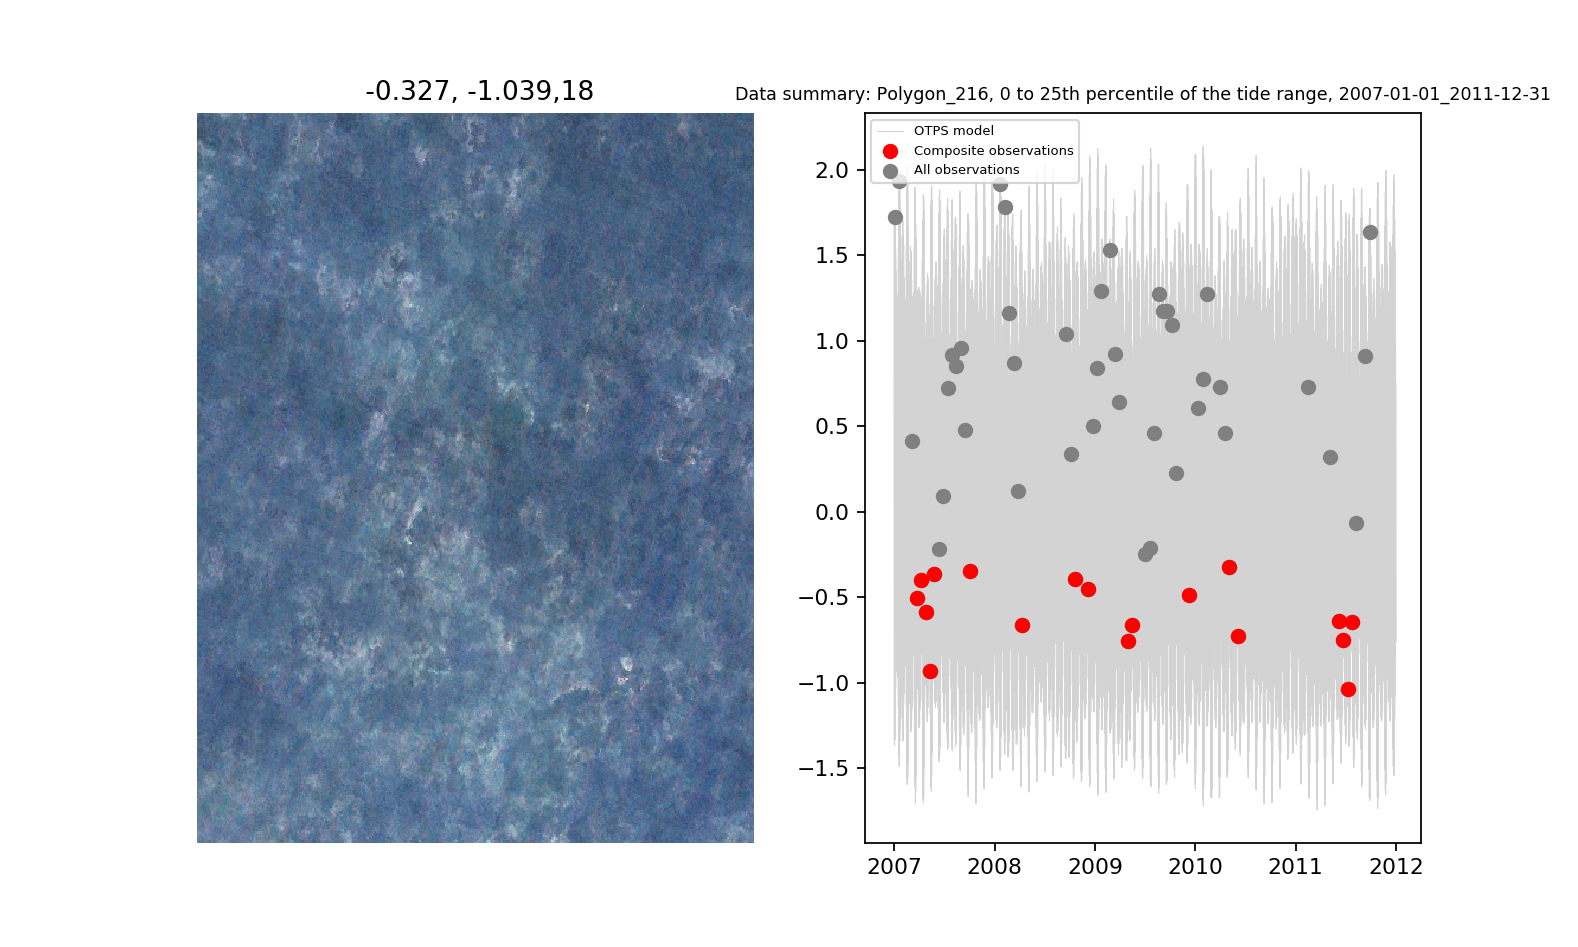

<IPython.core.display.Javascript object>


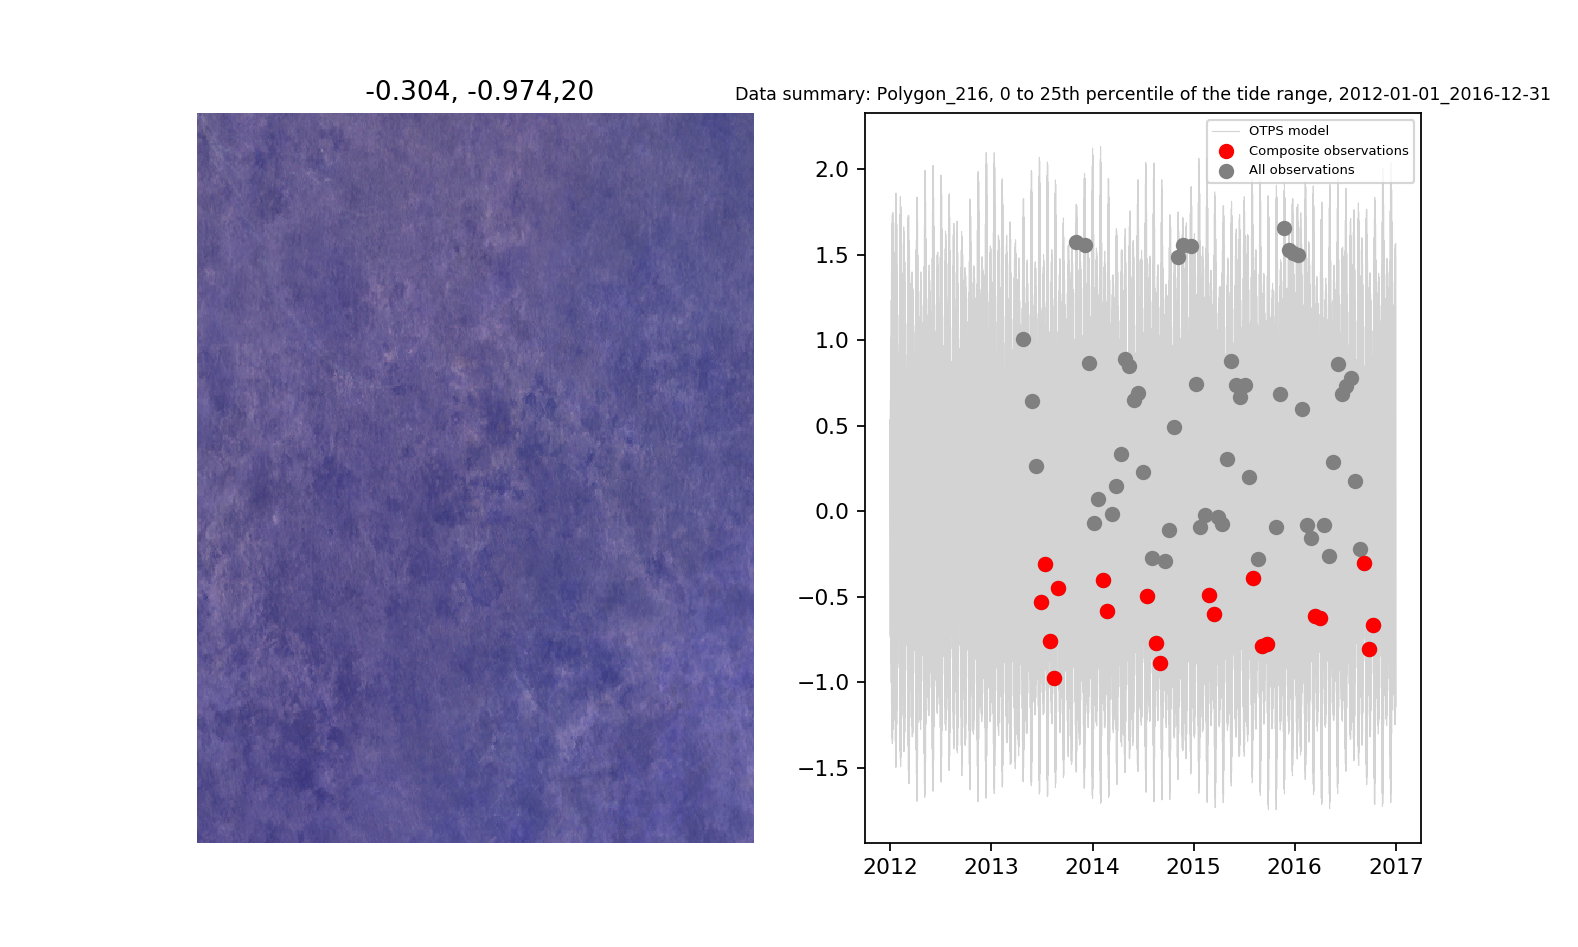

In [157]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


n = 0
fake_saturation = 4500
max_val = 0

for k,v in sorted(MY_GEO.items()):       
    false_col = MY_GEO[k].to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')   
    #false_col = m_data.to_array(dim='variable').sel(variable=['swir1', 'nir', 'green'])
    clipped_visible = false_col.where(false_col<fake_saturation).fillna(fake_saturation)
    max_val = clipped_visible.max(['y', 'x'])   
    break
 
for x in LIST:
    
    fig = plt.figure(figsize=(10,6))
    gs1 = GridSpec(1, 2)
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])
    #fig, ax1 = plt.subplots(1,1, sharex=True, sharey=True)
    # plot geomedian
     
    false_col = MY_GEO[x].to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
   
    clipped_visible = false_col.where(false_col<fake_saturation).fillna(fake_saturation)
    scale_image = (clipped_visible / max_val) 
    
    ax1.imshow(scale_image, interpolation='nearest', aspect='auto') 
    #ax1.set_title(i[0].split('_')[1].split('-')[0] + '-' + i[0].split('_')[2].split('-')[0] + MY_EPOCH[i[0]])
    ax1.set_title(MY_EPOCH[x])
    ax1.axis('off')
    plt.show()
   
    # Plot model
    #fig, ax2 = plt.subplots(1,2, sharex=True, sharey=True)
    model_epoch_plotdates=np.array(((pd.DatetimeIndex(model_epoch[LIST[n]].index)).to_datetime()).to_pydatetime(), \
                                   dtype=numpy.datetime64)
   
    ax2.plot(model_epoch_plotdates, model_epoch[LIST[n]].values, color="lightgray", zorder=1, label="OTPS model"\
            ,linewidth=0.5)
    
    # Plot observations used in plot
    obstiderangeepoch_plotdates=np.array(((pd.DatetimeIndex(obs_tide_range_epoch[LIST[n]].index)).to_datetime()).\
                                         to_pydatetime(), dtype=numpy.datetime64)
    ax2.scatter(obstiderangeepoch_plotdates, obs_tide_range_epoch[LIST[n]].Tide_height, marker="o", color="red", \
                zorder=3, label="Composite observations")
    
    # Plot all observations for epoch
    allobstiderangeepoch_plotdates=np.array(((pd.DatetimeIndex(all_obs_tide_range_epoch[LIST[n]].index)).\
                                             to_datetime()).to_pydatetime(), dtype=numpy.datetime64)
    ax2.scatter(allobstiderangeepoch_plotdates, all_obs_tide_range_epoch[LIST[n]].Tide_height, marker='o', \
                color="gray", zorder=2, label="All observations")
    
    plt.title("Data summary: "+str(LOC)+", "+ str(lower) + " to " + str(upper) + "th percentile of the tide range, "+ str(x), fontsize=8)
    plt.legend(fontsize=6)
    
    n=n+1
    plt.show()
    

In [ ]:
# 4.5 Repeat, selecting for tidal stage

In [ ]:
# 4.6 Show data summary as interactive plot

In [ ]:
# 5. Allow data mining via interactive plot

In [ ]:
# 5. Code for plot interactivity. 
#    Output only the scene corresponding to a user mouse click on the interactive data summary plot.